# Perturbation for cross-feeding consumer resource model 

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
import time
from collections import  defaultdict
import copy
from __future__ import division
import pandas as pd
from numpy.random import dirichlet
import numbers

import seaborn as sns

import pandas as pd
from itertools import product
#from tqdm import tqdm
from tqdm.notebook import tqdm
import pickle
import os
import time

from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'
from iterative_perturbation import general_perturbation_prediction
from iterative_perturbation import prediction_given_Sbool
from matplotlib.colors import Normalize, BoundaryNorm

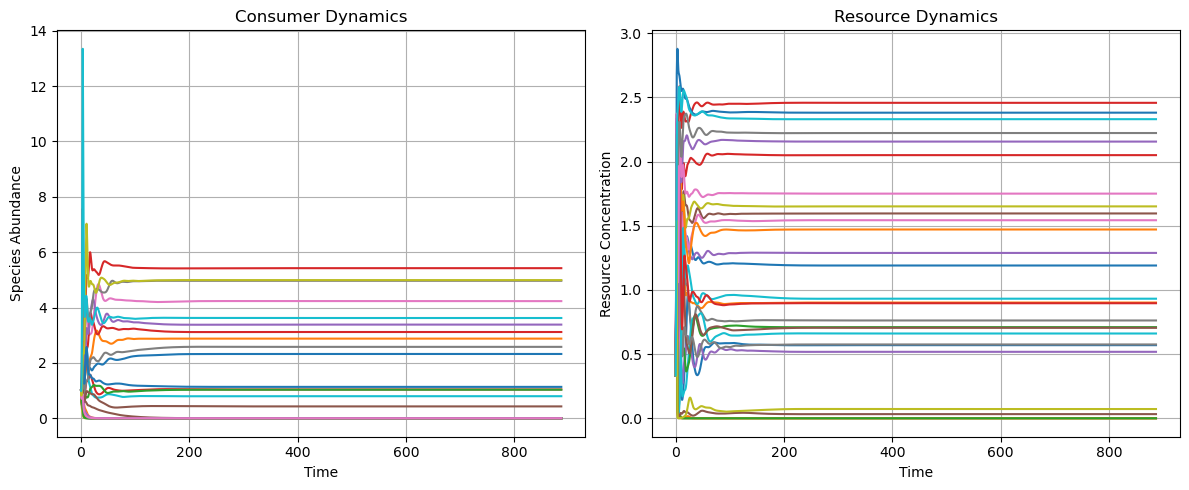

In [2]:


def simulate_monod_crm(initial_state, C, E, h, m, K,
                                 max_time=500000, steady_state_threshold=1e-12):
    """
    Simulate the ODE system until steady state or max_time is reached.

    Parameters:
    -----------
    initial_state : np.ndarray
        Concatenated vector [N_init, R_init], length S + M.
    C : np.ndarray
        Consumption matrix, shape (S, M).
    E : np.ndarray
        Effect matrix, shape (S, M).
    h : float
        Half-saturation constant.
    m : np.ndarray
        Species mortality vector, shape (S,).
    K : np.ndarray
        Resource carrying capacities, shape (M,).
    max_time : float
        Maximum simulation time.
    steady_state_threshold : float
        Steady state threshold for all derivatives.

    Returns:
    --------
    sol : OdeResult
        Output object from scipy's solve_ivp.
    """
    S, M = C.shape

    def Monod_CRM(t, state):
        N = state[:S]
        R = state[S:]
        
        growth_terms = C @ (R / (h + R))  # shape (S,)
        
        dNdt = N * (growth_terms - m)

        denom = h + R  # (S, M)
    
        consumption_terms = E.T @ N  /denom # shape (M,)
      
        dRdt = R * (K - R - consumption_terms)

        return np.concatenate([dNdt, dRdt])

    # Event to detect steady state
    def check_steady_state(t, y):
        derivatives = Monod_CRM(t, y)
        return np.max(np.abs(derivatives)) - steady_state_threshold

    check_steady_state.terminal = True
    check_steady_state.direction = -1  # Detect when system enters threshold
    
    sol = solve_ivp(
        Monod_CRM,
        t_span=(0, max_time),
        y0=initial_state.copy(),
        method='LSODA',
        atol=1e-10,
        rtol=1e-10,
        events=[check_steady_state]
    )

    if sol.t[-1] == max_time:
        print('max integration time reached')
        return None

    return sol

def generate_E(E_mean, top_species, resources, rho, zero_mean_c ):
    zero_mean_d = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    return E_mean/resources + rho * zero_mean_c   + np.sqrt(1 - rho**2) * zero_mean_d


def generate_model_params(top_species, resources, C_mean, C_std_dev, rho, u_mean, m_std_dev, k_mean, k_std_dev):
    zero_mean_c = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    C = C_mean/resources + zero_mean_c
    m = np.random.normal(u_mean, m_std_dev,top_species)
    E = generate_E(C_mean, top_species, resources, rho, zero_mean_c)
    k = np.random.normal(k_mean, k_std_dev,resources)
    return C, m, E, k

# Example simulation and plotting
import matplotlib.pyplot as plt

# Set parameters
S = 30  # Number of species
M = 30  # Number of resources
h = 2  # Half-saturation constant

mean_c = 3            # Mean consumption rate
C_std_dev = 1         # Standard deviation of consumption
rho = 1               # Correlation coefficient

# Generate model parameters
C, m, E, k = generate_model_params(S, M, mean_c, C_std_dev, rho, 
                                 u_mean=1, m_std_dev=0,
                                 k_mean=3, k_std_dev=0)

# Initial conditions
N0 = np.ones(S)  # Initial species abundances
R0 = np.ones(M)/3    # Initial resource concentrations at carrying capacity
initial_state = np.concatenate([N0, R0])
# Run simulation
sol = simulate_monod_crm(initial_state, C, E, h, m, k, max_time=10000,steady_state_threshold=1e-10)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot species abundances
for i in range(S):
    ax1.plot(sol.t, sol.y[i], label=f'Species {i+1}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Species Abundance')
#ax1.set_yscale('log')
ax1.grid(True)
ax1.set_title('Consumer Dynamics')

# Plot resource concentrations
for j in range(M):
    ax2.plot(sol.t, sol.y[S+j], label=f'Resource {j+1}')
ax2.set_xlabel('Time')
ax2.set_ylabel('Resource Concentration')
#ax2.set_yscale('log')
ax2.grid(True)
ax2.set_title('Resource Dynamics')


plt.tight_layout()
plt.show()







In [3]:
def find_steady_state(C, m, E, k, h, max_time=10000, survival_threshold=1e-5):
    """
    Run simulation and find the steady state abundances.
    
    Parameters:
    C: Consumption matrix
    m: Maintenance vector
    E: Conversion matrix
    k: Resource supply rates
    h: Half-saturation constant
    max_time: Maximum simulation time
    survival_threshold: Threshold below which species are considered extinct
    
    Returns:
    final_abundances: Array of steady state abundances, with extinct species set to 0
    """
    S, M = C.shape
    
    # Initial conditions
    N0 = np.ones(S)  # Initial species abundances
    R0 = np.ones(M)/3  # Initial resource concentrations
    initial_state = np.concatenate([N0, R0])
    
    
    sol = simulate_monod_crm(initial_state, C, E, h, m, k,
                               max_time=max_time, steady_state_threshold=1e-10)
    if sol is None:
        return None, None  
    
    # Get final abundances from the last timepoint
    final_abundances = sol.y[:S, -1]  # Only take species abundances, not resources
    
    # Set species below threshold to 0
    final_abundances[final_abundances < survival_threshold] = 0
    # Get final resource concentrations from the last timepoint
    final_resources = sol.y[S:, -1]  # Take resource concentrations after species abundances
    
    return final_abundances, final_resources
    

In [4]:
import numpy as np


def create_block_matrix(A, B, C, D):   

    # Create the block matrix using np.block
    block_matrix = np.block([
        [A, B],
        [C, D]
    ])
    
    return block_matrix

def make_A(C,E,Q):
    # Print shapes of input matrices

    zeros=np.zeros((len(C),len(C)))
    # Create the block matrix using create_block_matrix
    A = create_block_matrix(zeros, C,E.T, Q)
    
    return A

def make_X(N,R):
    X=np.concatenate((N,R))
    return X

def make_u(m,k):
    u=np.concatenate((-m,k))
    return u

#make_A(C,E,np.eye((len(C.T))))
def set_random_true(boolean_array, num_to_set_true): # for knockoffs
    # Get indices of False values in the array
    false_indices = np.where(boolean_array == False)[0]
    
    # If there are fewer False values than num_to_set_true, raise an error
    if len(false_indices) < num_to_set_true:
        raise ValueError("Number of False values is less than num_to_set_true.")
        
    # Randomly choose indices to set to True
    indices_to_set_true = np.random.choice(false_indices, num_to_set_true, replace=False)
    
    # Set the chosen indices to True
    boolean_array[indices_to_set_true] = True
    
    return boolean_array


def predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I, delta_m,knock_off, num_iters=50, momentum=0.1, E_IS_eff=None, C_I_eff=None,N_survival_threshold=1e-5,R_survival_threshold=1e-5):
    
    num_invaders=len(m_I)
    num_native=len(Cs)
    num_resources=len(Qs)
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(-ms,k)
    delta_u=make_u(delta_m,np.zeros(num_resources))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),-C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    if C_I_eff is not None:
        A_IS_eff=np.block([[np.zeros((num_invaders,num_native)),-C_I_eff]])
    u_I=-m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*num_resources)), dtype=bool)
    survival_threshold=np.concatenate((np.full(num_native+num_invaders,N_survival_threshold),np.full(num_resources,R_survival_threshold)))
    predicted_XList=general_perturbation_prediction(As,oldXs,us,delta_u,full_knock_off,A_II,A_IS,A_SI, u_I,num_iters=50, momentum=momentum, A_IS_eff=A_IS_eff, survival_threshold=survival_threshold)
    #predicted_XList=general_perturbation_prediction(As,oldXs,us,delta_u,full_knock_off,A_II,A_IS,A_SI, u_I,num_iters=50, momentum=momentum, A_IS_eff=A_IS_eff)
    perturbation_prediction = np.array(predicted_XList)[-1]  
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+num_resources]
    invader_N_prediction=perturbation_prediction[num_native+num_resources:]

    return np.concatenate((native_N_prediction,invader_N_prediction)), native_R_prediction



def info_predict_CRM_with_LV(Cs,Es, Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I,delta_m,N_simulator_Sbool,R_simulator_Sbool,C_I_eff=None):
    resources=len(k)
    num_invaders=len(m_I)
    num_native=len(Cs)
    
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(-ms,k)
    delta_u=make_u(delta_m,np.zeros(resources))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),-C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    if C_I_eff is not None:
        A_IS_eff=np.block([[np.zeros((num_invaders,num_native)),-C_I_eff]])
    u_I=-m_I
    
    Sbool_I=N_simulator_Sbool[len(Cs):]
    Sbool=np.concatenate((N_simulator_Sbool[:len(Cs)],R_simulator_Sbool))
    perturbation_prediction, screened_invader_impact, M_inv, invasion_fitness=prediction_given_Sbool(As,oldXs,us,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I,A_IS_eff=A_IS_eff)
    
    screened_invader_impact_N=screened_invader_impact[:-sum(R_simulator_Sbool)]
    screened_invader_impact_R=screened_invader_impact[-sum(R_simulator_Sbool):]
    
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+resources]
    invader_N_prediction=perturbation_prediction[num_native+resources:]
    
    return np.concatenate((native_N_prediction,invader_N_prediction)),native_R_prediction, screened_invader_impact_N,screened_invader_impact_R, M_inv, invasion_fitness


def consumer_invasion_and_knock_off(C, E, C_I, E_I, m, m_I, knock_off):
    not_knock_off= np.logical_not(knock_off)
    C_new=np.concatenate((C[not_knock_off],C_I))
    E_new=np.concatenate((E[not_knock_off],E_I))
    m_new = np.concatenate((m[not_knock_off], m_I))
    return C_new, E_new, m_new

def deduce_extinction_threshold_log(data):
    """
    Deduce a threshold for extinction in abundance data using the log distribution and the middle of the gap.
    
    Parameters:
    data (array-like): Array of abundance data.
    
    Returns:
    float: The deduced extinction threshold.
    """
    data = np.array(data)
    data_nonzero = data[data > 0]  # Remove zero or negative values to avoid log issues
    log_data = np.log(data_nonzero)
    
    # Sort the log-transformed data
    sorted_log_data = np.sort(log_data)
    
    # Find the middle of the largest gap in the log-transformed data
    log_gaps = np.diff(sorted_log_data)
    max_gap_index = np.argmax(log_gaps)
    
    middle_of_gap = (sorted_log_data[max_gap_index] + sorted_log_data[max_gap_index + 1]) / 2
    
    # Convert back from log scale to original scale
    threshold = np.exp(middle_of_gap)
    
    return threshold

def unpack_results(results):
    if not results:
        return {}
    # Extract all keys from the first result
    keys = results[0].keys()
    # Create a dictionary with each key mapped to a list of corresponding values
    return {key: [result[key] for result in results] for key in keys}

def form_matrices(C, E, N, R, h, C_I, E_I):
    """
    Form the mapped effective matrices C, E, Q, and vector C_I in perturbation theory for Monod CRM.

    Parameters:
    C (np.ndarray): Matrix C_{iα} with shape (S, M).
    E (np.ndarray): Matrix E_{jα} with shape (S, M).
    N (np.ndarray): Vector of species abundances N_j with shape (S,).
    R (np.ndarray): Vector of resource concentrations R_α with shape (M,).
    h (np.ndarray): Vector h_i (or h_j) with shape (S,).
    get_CI (bool): Whether to compute and return C_I.

    Returns:
    C_matrix (np.ndarray): \( C_{i\alpha} \to \frac{C_{i\alpha} h_i}{(h_i - R_\alpha)^2} \)
    E_matrix (np.ndarray): \( E_{j\alpha} \to \frac{E_{j\alpha}}{(h_j + R_\alpha)^2} \)
    Q_matrix (np.ndarray): \( Q_{\alpha\beta} = \delta_{\alpha\beta} - \delta_{\alpha\beta}\sum_j \frac{E_{j\alpha} N_j}{(h_j + R_\alpha)^2} \)
    C_I (np.ndarray): \( C_{0\alpha} = \sum_i \frac{C_{i\alpha}}{h_i + R_\alpha} \) if get_CI else None
    """
    S, M = C.shape
        # (S, 1) to broadcast with (S, M)
    R = R.reshape(1, M)      # (1, M) to broadcast with (S, M)

    # 1. C_matrix: elementwise
    C_eff = C * h / (h + R) ** 2

    # 2. E_matrix: elementwise
    E_eff = E / (h + R) 
    
    # 3. Q_matrix: diagonal matrix
    Q_diag = 1 - np.sum(E * N.reshape(S, 1) / (h + R) ** 2, axis=0)
    Q_eff = np.diag(Q_diag)

    # 4. invader vectors
    C_I_finv = C_I / (h + R)
    C_I_eff = C_I * h / (h + R) ** 2
    E_I_eff = E_I /  (h + R)


    return C_eff, E_eff, Q_eff, C_I_finv, C_I_eff, E_I_eff


In [5]:
# def update_ext_bool(original, shift, survival_threshold=1e-5): #bring those shifting to negatie to extinct
#     original_plus_shift=original+shift
#     Extbool=np.array([(x <= survival_threshold) for x in original_plus_shift])
#     return Extbool
# def general_perturbation_prediction(A,X,u,delta_u,knock_off,A_II,A_IS,A_SI, u_I, num_iters, momentum=0.1,immortal=None,A_IS_eff=None):
#     if delta_u is None:delta_u = np.zeros(len(u)) #perturbed environment
#     if knock_off is None:knock_off = np.array([False]*len(A), dtype=bool) #something that has to extinct
#     if immortal is None: immortal = np.array([False]*len(A), dtype=bool) #something that has to survive
        
#     sumX=np.sum(X)
#     num_immortal=sum(immortal)
#     num_invaders=len(A_II)
#     X_IList=[]
#     deltaXList=[]
#     predicted_XList=[]
#     Ebool=np.array(knock_off, dtype=bool)  # Ensure boolean type
#     Sbool= np.logical_not(Ebool)
#     Ebool_I = np.array([False]*num_invaders, dtype=bool)  # Ensure boolean type
#     Sbool_I= np.logical_not(Ebool_I)
#     deltaX = -sumX*Ebool.astype(int)
#     X_I=np.zeros(num_invaders)
    
#     for i in range(num_iters):
#         Sbool= np.logical_not(Ebool)
#         Sbool_I= np.logical_not(Ebool_I) 
        
#         X_S = X[Sbool]
#         X_E = X[Ebool]
#         A_SS_inv=np.linalg.inv(A[Sbool,::][::,Sbool])
#         A_SE=A[Sbool,::][::,Ebool]
#         delta_u_S=delta_u[Sbool]
#         #num_invaders=sum(Sbool_I)
#         if num_invaders>0:
#             A_IS_s=A_IS[Sbool_I,::][::,Sbool]
#             A_SI_s=A_SI[Sbool,::][::,Sbool_I]
#             A_II_s=A_II[Sbool_I,::][::,Sbool_I]  
#             u_I_s=u_I[Sbool_I]
#             X_I_s=X_I[Sbool_I]
#             if A_IS_eff is not None:
#                 A_IS_eff_s=A_IS_eff[Sbool_I,::][::,Sbool]
#                 M_inv=np.linalg.inv(A_II_s-A_IS_eff_s@A_SS_inv@A_SI_s)
#                 X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_eff_s@A_SS_inv@(delta_u_S+A_SE@X_E))
#             else:
#                 M_inv=np.linalg.inv(A_II_s-A_IS_s@A_SS_inv@A_SI_s)
#                 X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_s@A_SS_inv@(delta_u_S+A_SE@X_E))

#             #removing invaders if it goes negative or explode to infinity
#             for j in range(len(X_I_s)):
#                 if X_I_s[j]<0 or X_I_s[j]>sumX:
#                     X_I_s[j]=0
#                     Ebool_I[j]=True
                    
#             X_I[Sbool_I]=X_I_s
            
#             deltaX_new=A_SS_inv@(delta_u_S-A_SI_s@X_I_s+A_SE@X_E)
        
#         else: 
#             deltaX_new=A_SS_inv@(delta_u_S+A_SE@X_E)
#             #X_I=[]
        
#         #if np.sum((deltaX_new-deltaX[Sbool])**2)<accuracy: #check convergence, break if converged
#         #    break
#         if i==0: #first iteration
#             deltaX[Sbool]=deltaX_new
#         else:   
#             # instead of update to delta_new directly, we do momentum updates to improve convergence 
#             deltaX[Sbool]=copy.deepcopy(deltaX[Sbool])*momentum+(1-momentum)*deltaX_new
            
#         XExtgrowth=u[Ebool]-A[Ebool,::][::,Sbool]@(X_S+deltaX[Sbool])
#         if num_invaders>0: X_IExtgrowth=u_I[Ebool_I]-A_IS[Ebool_I,::][::,Sbool]@(X_S+deltaX[Sbool])
        
#         oldEbool=copy.deepcopy(Ebool)
        
#         #bringing back the species with positive growth rates except knock-offs
#         Ebool[Ebool]=[(x < 1e-8) for x in XExtgrowth] 
#         # print('Ebool, knock_off',Ebool, knock_off)
#         Ebool[knock_off]=knock_off[knock_off]
#         if num_invaders>0: Ebool_I[Ebool_I]=[(x < 0) for x in X_IExtgrowth] 
        
#         #removing species with negative abundance after proposed shift
#         Ebool[Sbool] = update_ext_bool(X[Sbool], deltaX[Sbool])

#         #make sure all immortal species are surviving 
#         Ebool[immortal]=np.array([False]*num_immortal)
                
#         #save result
#         X_IList.append(X_I)
#         deltaXList.append(deltaX)
        
#         predicted_X=np.concatenate((np.clip(deltaX+X, 0, None),X_I))
#         predicted_XList.append(predicted_X)
        
#         #check convergence
#         if np.all(oldEbool==Ebool):
#             break
#     return predicted_XList


In [6]:
import numpy as np
import copy

def update_ext_bool(original, shift, survival_threshold): #bring those shifting to negative to extinct
    original_plus_shift = original + shift
    Extbool = original_plus_shift <= survival_threshold
    return Extbool

def general_perturbation_prediction(A,X,u,delta_u,knock_off,A_II,A_IS,A_SI, u_I, num_iters, momentum=0.1,survival_threshold=1e-5,A_IS_eff=None):
    #A_IS_eff is relevant only for nonlinear consumer dynamics, in that case A_IS is the effective interaction appear in invasion fitness, and A_IS_eff is the linearied interaction. In other cases, they are the same.
    num_invaders=len(A_II)
    num_species=len(A)
    #if survival threshold is a scalar, then it is the same for all species
    if np.isscalar(survival_threshold): 
        survival_threshold = np.full(num_invaders + num_species, survival_threshold)
    if delta_u is None:delta_u = np.zeros(len(u)) #perturbed environment
    if knock_off is None:knock_off = np.array([False]*len(A), dtype=bool) #something that has to extinct
    
    #list to save the predicted abundances of all iterations
    predicted_XList=[]

    #initialize iterative variables
    Ebool=knock_off
    Sbool= np.logical_not(Ebool)
    Ebool_I = np.array([False]*num_invaders)
    Sbool_I= np.logical_not(Ebool_I)
    deltaX = -np.sum(X)*Ebool.astype(int)
    X_I=np.zeros(num_invaders)

    for i in range(num_iters):
        Sbool= np.logical_not(Ebool)
        Sbool_I= np.logical_not(Ebool_I) 
        X_S = X[Sbool]
        X_E = X[Ebool]
        A_SS_inv=np.linalg.inv(A[Sbool,::][::,Sbool])
        A_SE=A[Sbool,::][::,Ebool]
        delta_u_S=delta_u[Sbool]
        if num_invaders>0:
            A_IS_s=A_IS[Sbool_I,::][::,Sbool]
            A_SI_s=A_SI[Sbool,::][::,Sbool_I]
            A_II_s=A_II[Sbool_I,::][::,Sbool_I]  
            u_I_s=u_I[Sbool_I]
            X_I_s=X_I[Sbool_I]
            
            if A_IS_eff is not None:
                A_IS_eff_s=A_IS_eff[Sbool_I,::][::,Sbool]
                M_inv=np.linalg.inv(A_II_s-A_IS_eff_s@A_SS_inv@A_SI_s)
                X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_eff_s@A_SS_inv@(delta_u_S+A_SE@X_E))

            else:
                print('A_IS_eff is None?')
                # M_inv=np.linalg.inv(A_II_s-A_IS_s@A_SS_inv@A_SI_s)
                # X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_s@A_SS_inv@(delta_u_S+A_SE@X_E))

            #removing invaders if it goes lower than survival threshold or explode to infinity
            for j in range(len(X_I_s)):
                if X_I_s[j]<survival_threshold[num_invaders+j] or X_I_s[j]>np.sum(X):
                    X_I_s[j]=0
                    Ebool_I[j]=True
                    
            X_I[Sbool_I]=X_I_s
            
            deltaX_new=A_SS_inv@(delta_u_S-A_SI_s@X_I_s+A_SE@X_E)
        
        else: 
            deltaX_new=A_SS_inv@(delta_u_S+A_SE@X_E)
        
        if i==0: #first iteration
            deltaX[Sbool]=deltaX_new
        else:   
            # instead of update to delta_new directly, we do momentum updates to improve convergence 
            deltaX[Sbool]=copy.deepcopy(deltaX[Sbool])*momentum+(1-momentum)*deltaX_new
            
        XExtgrowth=u[Ebool]-A[Ebool,::][::,Sbool]@(X_S+deltaX[Sbool])
        if num_invaders>0: X_IExtgrowth=u_I[Ebool_I]-A_IS[Ebool_I,::][::,Sbool]@(X_S+deltaX[Sbool])
        
        oldEbool=copy.deepcopy(Ebool)

        #bringing back the species with positive growth rates except knock-offs except for the final iteration
        Ebool[Ebool]=XExtgrowth<survival_threshold[num_invaders:][Ebool] 
        Ebool[knock_off]=knock_off[knock_off]
        
        if num_invaders>0:
            Ebool_I[Ebool_I] = X_IExtgrowth < survival_threshold[:num_invaders][Ebool_I]
        #if num_invaders>0: Ebool_I[Ebool_I]=[(x < 0) for x in X_IExtgrowth] 
            
        #removing species with negative abundance after proposed shift
        Ebool[Sbool] = update_ext_bool(X[Sbool], deltaX[Sbool],survival_threshold=survival_threshold[:num_species][Sbool])
                
        predicted_X=np.concatenate((np.clip(deltaX+X, 0, None),X_I))
        predicted_XList.append(predicted_X)
        
        #check convergence
        if np.all(oldEbool==Ebool):
            break
        
    # make the final predictions without memory of previous iterations
    predicted_X, _, _, _ = prediction_given_Sbool(A,X,u,delta_u,A_II,A_IS,A_SI, u_I,Sbool, Sbool_I,A_IS_eff=A_IS_eff)
    final_Sbool=predicted_X > survival_threshold 
    predicted_X, _, _, _ = prediction_given_Sbool(A,X,u,delta_u,A_II,A_IS,A_SI, u_I,final_Sbool[:-num_invaders], final_Sbool[-num_invaders:],A_IS_eff=A_IS_eff)
    predicted_X = np.clip(predicted_X, 0, None)
    predicted_XList.append(predicted_X)
    
    return predicted_XList

#this function produce the prediction given the information of what goes extinct after invasions
def prediction_given_Sbool(A,X,u,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I,A_IS_eff=None): 
    num_invaders=len(u_I)    
    Ebool= np.logical_not(Sbool)
    X_I=np.zeros(num_invaders)
    deltaX=np.zeros(len(A))
    
    X_S = X[Sbool]
    X_E = X[Ebool]
    A_SS_inv=np.linalg.inv(A[Sbool,::][::,Sbool])
    A_SE=A[Sbool,::][::,Ebool]
    delta_u_S=delta_u[Sbool]
    A_IS_s=A_IS[Sbool_I,::][::,Sbool]
    A_SI_s=A_SI[Sbool,::][::,Sbool_I]
    A_II_s=A_II[Sbool_I,::][::,Sbool_I]  
    u_I_s=u_I[Sbool_I]
    X_I_s=X_I[Sbool_I]

    if A_IS_eff is not None:
        A_IS_eff_s=A_IS_eff[Sbool_I,::][::,Sbool]
        M_inv=np.linalg.inv(A_II_s-A_IS_eff_s@A_SS_inv@A_SI_s)
        X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_eff_s@A_SS_inv@(delta_u_S+A_SE@X_E))
    else:
        M_inv=np.linalg.inv(A_II_s-A_IS_s@A_SS_inv@A_SI_s)
        X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_s@A_SS_inv@(delta_u_S+A_SE@X_E))
    
    deltaXs=A_SS_inv@(delta_u_S-A_SI_s@X_I_s+A_SE@X_E)
    
    deltaX[Sbool]=deltaXs
    X_I[Sbool_I]=X_I_s
    newX=deltaX+X
    newX[Ebool]= 0
    predicted_X=np.concatenate((newX,X_I))
    screened_invader_impact=np.ndarray.flatten(A_SS_inv@A_SI_s)
    invasion_fitness=np.ndarray.flatten(-A_IS@X+u_I)
    
    return predicted_X, screened_invader_impact, M_inv, invasion_fitness


In [7]:
from multiprocess import Pool

assumptions = {
    "num_knock_offs": 0,
    "num_invaders": 1,
    "top_species": 30,
    "resources": 30,
    "C_mean": 3,
    "C_std_dev": 1,
    "rho": 1,
    "u_mean": 1,
    "u_std_dev": 0,
    "k_mean": 3,
    "k_std_dev": 0,
    "deltam_mean": 0,
    "deltam_std_dev": 0,    
    'h':3,
}

def simulate_single_system(assumptions):
    np.random.seed(None)
    # Extract parameters from the assumptions dictionary
    top_species = assumptions['top_species']
    resources = assumptions['resources']
    C_mean = assumptions['C_mean']
    C_std_dev = assumptions['C_std_dev']
    rho = assumptions['rho']
    u_mean = assumptions['u_mean']
    u_std_dev = assumptions['u_std_dev']
    k_mean = assumptions['k_mean']
    k_std_dev = assumptions['k_std_dev']
    num_knock_offs = assumptions['num_knock_offs']
    num_invaders = assumptions['num_invaders']
    deltam_mean = assumptions['deltam_mean']
    deltam_std_dev = assumptions['deltam_std_dev']
    N_threshold = assumptions.get('N_threshold', 1e-3)
    R_threshold = assumptions.get('R_threshold', 1e-3)
    h=assumptions['h']

    # Generate model parameters for each system
    C, m, E, k = generate_model_params(top_species, resources, C_mean, C_std_dev, rho,
                                          u_mean, u_std_dev, k_mean, k_std_dev)
    
    # Simulate the initial system
    oldN, oldR = find_steady_state(C,m,E,k,h,  max_time=200000, survival_threshold=1e-5)
    while oldN is None:
        print('Not converged, sampled another system')
        C, m, E, k = generate_model_params(top_species, resources, C_mean, C_std_dev, rho,
                                          u_mean, u_std_dev, k_mean, k_std_dev)
        oldN, oldR = find_steady_state(C,m,E,k,h,  max_time=200000, survival_threshold=1e-5)

    # Determine extinction thresholds
    N_Sbool = [(x > N_threshold) for x in oldN]
    R_Sbool = [(x > R_threshold) for x in oldR]
    
    num_native = sum(N_Sbool)
    num_sur_resources = sum(R_Sbool)

    Cs = C[N_Sbool][:, R_Sbool]
    Es = E[N_Sbool][:, R_Sbool]
    ms = m[N_Sbool]
    oldNs = oldN[N_Sbool]
    oldRs = oldR[R_Sbool]
    ks = k[R_Sbool]
    
    # Sample knockoff
    knock_off = np.array([False] * num_native,dtype=bool)
    knock_off = set_random_true(knock_off, num_knock_offs)
    not_knock_off = np.concatenate((np.logical_not(knock_off), np.array([True] * num_invaders)))

    # Sample invaders until invasion fitness is positive
    continue_sampling = True
    while continue_sampling:
        C_I, m_I, E_I, _ = generate_model_params(num_invaders,
                                                    num_sur_resources,
                                                    C_mean,
                                                    C_std_dev,
                                                    rho,
                                                    u_mean,
                                                    u_std_dev,
                                                    k_mean,
                                                    k_std_dev)
        if C_I @ (oldRs/(h+oldRs)) - m_I > 0:
            continue_sampling = False

        # Sample environmental perturbation
        delta_m = np.random.normal(deltam_mean, deltam_std_dev, num_native)

        # Add invaders and remove knockoffs
        new_top_species = num_native + num_invaders - num_knock_offs
        new_initial_state = np.random.rand(new_top_species + num_sur_resources)

        # Simulate the new system with the perturbation
        C_new, E_new, m_new = consumer_invasion_and_knock_off(Cs,
                                                            Es,
                                                            C_I,
                                                            E_I,
                                                            ms + delta_m,
                                                            m_I,
                                                            knock_off)
        
        newN = np.zeros(new_top_species)
        
        newN[not_knock_off], newR = find_steady_state(C_new,
                                                        m_new,
                                                        E_new,
                                                        ks,
                                                        h,
                                                        max_time=200000, 
                                                        survival_threshold=1e-5)
        if newR is None: 
            continue_sampling=True # sample another invader if it does not converge
            continue

    N_simulator_Sbool = [(x > N_threshold) for x in newN]
    R_simulator_Sbool = [(x > R_threshold) for x in newR]
    C_eff, E_eff, Q_eff, C_I_finv, C_I_eff, E_I_eff = form_matrices(Cs, Es, oldNs, oldRs, h, C_I, E_I)
    
    # Compute perturbation prediction with iterative method
    N_prediction,R_prediction=predict_CRM_with_LV(C_eff,
                                                  E_eff,
                                                  Q_eff,
                                                  oldNs,
                                                  oldRs,
                                                  ms,
                                                  ks,
                                                  E_I_eff,
                                                  C_I_finv,
                                                  m_I,
                                                  delta_m,
                                                  knock_off,
                                                  num_iters=50,
                                                  momentum=0.1,
                                                  C_I_eff=C_I_eff,
                                                  N_survival_threshold=N_threshold,
                                                  R_survival_threshold=R_threshold)
    info_Nprediction, info_Rprediction,\
    screened_invader_impact_N,\
    screened_invader_impact_R,\
    Minv,invasion_fitness = info_predict_CRM_with_LV(C_eff,
                                    E_eff,
                                    Q_eff, 
                                    oldNs,
                                    oldRs,
                                    ms,
                                    ks,
                                    E_I_eff,
                                    C_I_finv,
                                    m_I,
                                    delta_m,
                                    N_simulator_Sbool,
                                    R_simulator_Sbool,
                                    C_I_eff=C_I_eff)
    
    return {"simulationN_after": newN,
            "simulationR_after": newR,
            "simulationN_before": oldNs,
            "simulationR_before": oldRs,
            "predictionNs": N_prediction,
            "predictionRs": R_prediction,
            "info_Nprediction": info_Nprediction,
            "info_Rprediction": info_Rprediction,
            "invader_ODE_steady_states": newN[-1],
            "invader_predictions": N_prediction[-1],
            "sim_Nbools": N_simulator_Sbool,
            "sim_Rbools": R_simulator_Sbool,
            "prediction_Nbool": N_prediction > N_threshold,
            "prediction_Rbool": R_prediction > R_threshold,
            "screened_invader_impact_N": screened_invader_impact_N,
            "screened_invader_impact_R": screened_invader_impact_R,
            "Minv": Minv,
            "invasion_fitness": invasion_fitness
    }

num_systems = 640



if __name__ == '__main__':
     with Pool() as pool:
         temp_results=[pool.apply_async(simulate_single_system,args=(assumptions,))
                       for _ in range(num_systems)]
         
         output_data=[res.get() for res in temp_results]


max integration time reached
max integration time reached
Not converged, sampled another system
max integration time reached
Not converged, sampled another system


In [8]:
def unpack_results(results):
    if not results:
        return {}
    # Extract all keys from the first result
    keys = results[0].keys()
    # Create a dictionary with each key mapped to a list of corresponding values
    return {key: [result[key] for result in results] for key in keys}
monod_unpacked_data = unpack_results(output_data)




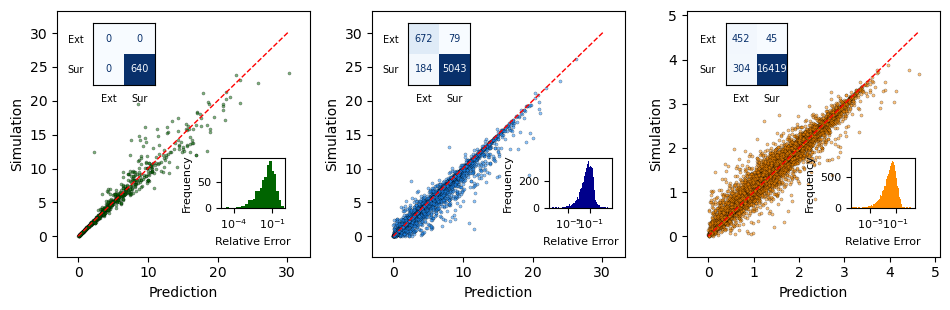

In [9]:
from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()


# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3, figure_width * 1))


# Filter data for positive predictions
sim_Nbools_concatenated = np.concatenate([arr[:-1] for arr in monod_unpacked_data['sim_Nbools']])
prediction_Nbool_concatenated = np.concatenate([arr[:-1] for arr in monod_unpacked_data['prediction_Nbool']])
N_intersection = [a and b for a, b in zip(sim_Nbools_concatenated, prediction_Nbool_concatenated)]
positive_indices_N = np.array(N_intersection) > 0

# Filter data for positive predictions
sim_Rbools_concatenated = np.concatenate(monod_unpacked_data['sim_Rbools'])
prediction_Rbool_concatenated = np.concatenate(monod_unpacked_data['prediction_Rbool'])
R_intersection = [a and b for a, b in zip(sim_Rbools_concatenated, prediction_Rbool_concatenated)]
positive_indices_R = np.array(R_intersection) > 0

filtered_simulationR_after = np.concatenate(monod_unpacked_data['simulationR_after'])[positive_indices_R]
filtered_predictionRs = np.concatenate(monod_unpacked_data['predictionRs'])[positive_indices_R]

simulationN_after_concatenated = np.concatenate([arr[:-1] for arr in monod_unpacked_data['simulationN_after']])
predictionN_concatenated = np.concatenate([arr[:-1] for arr in monod_unpacked_data['predictionNs']])
filtered_simulationN_after = simulationN_after_concatenated[positive_indices_N]
filtered_predictionNs = predictionN_concatenated[positive_indices_N]


# Scatter plot for N (reversed axes)
maxN = np.max(np.concatenate(monod_unpacked_data['predictionNs'][:-1]))
scatter_n = ax[1].scatter(filtered_predictionNs, filtered_simulationN_after, s=5, alpha=0.5, linewidth=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxN], [0, maxN], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_ylim(-maxN * 0.1, 1.1 * maxN)
#ax[1].set_title(f'consumer $N_i$')

# Add confusion matrix inset for N
inset_ax_n = ax[1].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Nbools_concatenated, prediction_Nbool_concatenated, ax=inset_ax_n)


# Histogram for relative error of N
ax_hist1 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist1.hist(np.log10(np.abs(filtered_simulationN_after - filtered_predictionNs) / filtered_simulationN_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist1.set_xlabel('Relative Error', fontsize=8)
ax_hist1.set_ylabel('Frequency', fontsize=8)
ax_hist1.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist1.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist1.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist1.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels


# Scatter plot for R 
maxR = np.max(np.concatenate(monod_unpacked_data['predictionRs']))
scatter_r = ax[2].scatter(filtered_predictionRs, filtered_simulationR_after, s=5, alpha=0.5, linewidth=0.3, c='darkorange', edgecolors='black')
ax[2].plot([0, maxR], [0, maxR], color='r', linestyle='dashed', linewidth=1)
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Simulation')
ax[2].set_xlim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_ylim(-maxR * 0.1, 1.1 * maxR)
#ax[2].set_title(f'resource $R_α$')

# Add confusion matrix inset for R
inset_ax_r = ax[2].inset_axes([0.15, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Rbools_concatenated, prediction_Rbool_concatenated, ax=inset_ax_r)

# Histogram for relative error of R
ax_hist2 = ax[2].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after), bins='auto', color='darkorange', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist2.set_xlim([-8, 2])  # Set x-axis limits

ax_hist2.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels


# simulation_invader = np.array(monod_unpacked_data['invader_ODE_steady_states'])
# prediction_invader = np.array(monod_unpacked_data['invader_predictions'])
simulation_invader = np.array([x[-1] for x in monod_unpacked_data['simulationN_after']])
prediction_invader = np.array([x[-1] for x in monod_unpacked_data['predictionNs']])


sim_invader_bool =  np.array([x[-1] for x in monod_unpacked_data['sim_Nbools']])
pred_invader_bool =  np.array([x[-1] for x in monod_unpacked_data['prediction_Nbool']])

N0_intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]

N0_positive_indices = np.array(N0_intersection) > 0
#print(sim_invader_bool,pred_invader_bool)

# Filter N_0 data for positive predictions
filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]
#r2_n0 = r2_score(filtered_simulation_invader, filtered_prediction_invader)

# Handle potential division by zero and inf/nan values for R histogram
relative_error_R = np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after
relative_error_R = relative_error_R[np.isfinite(relative_error_R) & (relative_error_R > 0)]  # Remove zeros and inf/nan
if len(relative_error_R) > 0:
    log_relative_error_R = np.log10(relative_error_R)
    log_relative_error_R = log_relative_error_R[np.isfinite(log_relative_error_R)]  # Remove any remaining inf/nan after log

# Scatter plot for N_0 
maxN0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.5, linewidth=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxN0], [0, maxN0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_ylim(-maxN0 * 0.1, 1.1 * maxN0)
#ax[0].set_title(f'invader $N_0$')

# Add confusion matrix inset for N_0
inset_ax_n0 = ax[0].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_invader_bool, pred_invader_bool, ax=inset_ax_n0)

# Histogram for relative error of N_0
ax_hist0 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)

ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xlim([-5, 0])  # Set x-axis limits from 10^-2 to 10^1

ax_hist0.set_xticks([-4, -1])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-4}$', '$10^{-1}$'])  # Replace with your desired tick labels

plt.tight_layout()
fig.savefig("Monod_work.pdf", format="pdf")
fig.savefig("Monod_work.svg", format="svg")

plt.show()




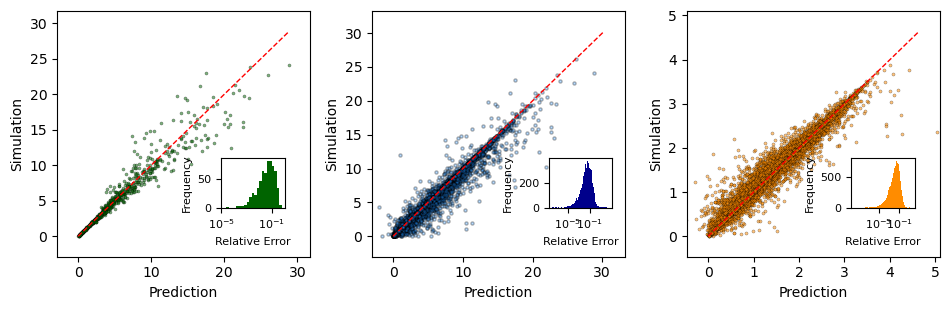

In [ ]:
 from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()


# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3, figure_width * 1))

# Filter data for positive predictions
sim_Nbools_concatenated = np.concatenate(monod_unpacked_data['sim_Nbools'])
prediction_Nbool_concatenated = np.concatenate(monod_unpacked_data['prediction_Nbool'])
intersection = [a and b for a, b in zip(sim_Nbools_concatenated, prediction_Nbool_concatenated)]
positive_indices_N = np.array(intersection) > 0

# Filter data for positive predictions
sim_Rbools_concatenated = np.concatenate(monod_unpacked_data['sim_Rbools'])
prediction_Rbool_concatenated = np.concatenate(monod_unpacked_data['prediction_Rbool'])
intersection = [a and b for a, b in zip(sim_Rbools_concatenated, prediction_Rbool_concatenated)]
positive_indices_R = np.array(intersection) > 0

filtered_simulationR_after = np.concatenate(monod_unpacked_data['simulationR_after'])[positive_indices_R]
filtered_predictionRs = np.concatenate(monod_unpacked_data['info_Rprediction'])[positive_indices_R]


filtered_simulationN_after = np.concatenate(monod_unpacked_data['simulationN_after'])[positive_indices_N]
filtered_predictionNs = np.concatenate(monod_unpacked_data['info_Nprediction'])[positive_indices_N]

# Calculate R^2 values
#r2_n = r2_score(filtered_simulationN_after, filtered_predictionNs)
#r2_r = r2_score(filtered_simulationR_after, filtered_predictionRs)

# Scatter plot for N (reversed axes)
maxN = np.max(np.concatenate(monod_unpacked_data['predictionNs']))
scatter_n = ax[1].scatter(filtered_predictionNs, filtered_simulationN_after, s=5, alpha=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxN], [0, maxN], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_ylim(-maxN * 0.1, 1.1 * maxN)
#ax[1].set_title(f'consumer $N_i$')


# Histogram for relative error of N
ax_hist1 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist1.hist(np.log10(np.abs(filtered_simulationN_after - filtered_predictionNs) / filtered_simulationN_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist1.set_xlabel('Relative Error', fontsize=8)
ax_hist1.set_ylabel('Frequency', fontsize=8)
ax_hist1.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist1.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist1.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist1.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels


# Scatter plot for R 
maxR = np.max(np.concatenate(monod_unpacked_data['predictionRs']))
scatter_r = ax[2].scatter(filtered_predictionRs, filtered_simulationR_after, s=5, alpha=0.5, linewidth=0.3, c='darkorange', edgecolors='black')
ax[2].plot([0, maxR], [0, maxR], color='r', linestyle='dashed', linewidth=1)
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Simulation')
ax[2].set_xlim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_ylim(-maxR * 0.1, 1.1 * maxR)
#ax[2].set_title(f'resource $R_α$')


# Histogram for relative error of R
ax_hist2 = ax[2].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after), bins='auto', color='darkorange', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist2.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels


simulation_invader = np.array([x[-1] for x in monod_unpacked_data['simulationN_after']])
prediction_invader = np.array([x[-1] for x in monod_unpacked_data['info_Nprediction']])


sim_invader_bool =  np.array([x[-1] for x in monod_unpacked_data['sim_Nbools']])
pred_invader_bool =  np.array([x[-1] for x in monod_unpacked_data['prediction_Nbool']])

intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0
#print(sim_invader_bool,pred_invader_bool)

# Filter N_0 data for positive predictions
filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]
#r2_n0 = r2_score(filtered_simulation_invader, filtered_prediction_invader)


# Scatter plot for N_0 
maxN0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.5, linewidth=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxN0], [0, maxN0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction given ')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_ylim(-maxN0 * 0.1, 1.1 * maxN0)
#ax[0].set_title(f'invader $N_0$')

# Histogram for relative error of N_0
ax_hist0 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xticks([-5, -1])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-5}$', '$10^{-1}$'])  # Replace with your desired tick labels

plt.tight_layout()
fig.savefig("Monod_work_with_info.svg", format="svg")
fig.savefig("Monod_work_with_info.pdf", format="pdf")

plt.show()

In [11]:
monod_unpacked_data.keys()

dict_keys(['simulationN_after', 'simulationR_after', 'simulationN_before', 'simulationR_before', 'predictionNs', 'predictionRs', 'info_Nprediction', 'info_Rprediction', 'invader_ODE_steady_states', 'invader_predictions', 'sim_Nbools', 'sim_Rbools', 'prediction_Nbool', 'prediction_Rbool', 'screened_invader_impact_N', 'screened_invader_impact_R', 'Minv', 'invasion_fitness'])

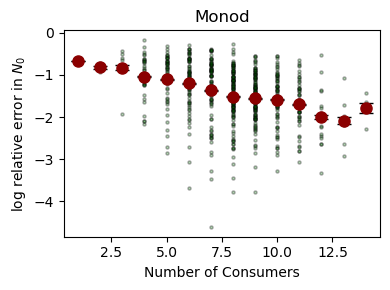

In [12]:
n_consumers=[]
similarity_score =[]
for sim_bool, pred_bool in zip(monod_unpacked_data['sim_Nbools'], monod_unpacked_data['prediction_Nbool']):
    # Get intersection of where both sim and pred are True
    intersection = np.logical_and(sim_bool[:-1], pred_bool[:-1])
    # Count number of True values
    if sim_bool[-1]:
        n_consumers.append(np.sum(intersection))
        similarity_score.append(np.sum(intersection)/len(sim_bool))



# # Calculate relative error for N_0
relative_error_N0 = np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader

# Create arrays to store mean and percentiles for each unique number of consumers
unique_n_consumers = np.unique(n_consumers)
mean_errors = []
error_bars = []
# percentile_25 = []
# percentile_75 = []

# Calculate statistics for each unique number of consumers
for n in unique_n_consumers:

    mask = np.array(n_consumers) == n
    
    errors = relative_error_N0[mask]
    
    # Calculate statistics in log scale
    log_errors = np.log10(errors)
    mean_errors.append(np.mean(log_errors))
    error_bars.append(np.std(log_errors)/len(errors))
    # percentile_25.append(np.percentile(log_errors, 25))
    # percentile_75.append(np.percentile(log_errors, 75))

# Convert back to linear scale
# mean_errors = 10**np.array(mean_errors)
# percentile_25 = 10**np.array(percentile_25)
# percentile_75 = 10**np.array(percentile_75)

# Create error bars (asymmetric in log scale)
# yerr_low = mean_errors - percentile_25
# yerr_high = percentile_75 - mean_errors

# Create new figure
plt.figure(figsize=(4, 3))

# Plot mean with error bars
plt.errorbar(unique_n_consumers, mean_errors, yerr=error_bars, 
             fmt='o', capsize=5, capthick=1, ecolor='black', 
             markersize=8, color='darkred', label='Mean with standard error')
plt.scatter(n_consumers, np.log10(relative_error_N0), alpha=0.3, s=5, c='darkgreen', edgecolor='black')

#plt.yscale('log')
plt.xlabel('Number of Consumers')
plt.ylabel('log relative error in $N_0$')
plt.title('Monod')
#plt.legend()

plt.tight_layout()
plt.savefig("Monod_mean_error_vs_consumers.pdf", format="pdf")
plt.show()


In [13]:
print(len(n_consumers), len(np.log10(relative_error_N0)))

640 640


In [14]:
def shift_invader_impacts(unpacked_data):
    # Extract data from unpacked_data
    invader_abundance = [arr[-1] for arr in unpacked_data['simulationN_after']]
    
    simulationN_before = unpacked_data['simulationN_before']
    simulationN_after = unpacked_data['simulationN_after']
    sim_Nbools = unpacked_data['sim_Nbools']
    sim_Rbools = unpacked_data['sim_Rbools']
    simulationR_before = unpacked_data['simulationR_before']
    simulationR_after = unpacked_data['simulationR_after']
    
    screened_invader_impact_N = unpacked_data['screened_invader_impact_N']
    screened_invader_impact_R = unpacked_data['screened_invader_impact_R']

    # Calculate N_shifts
    N_shifts = []
    for i in range(len(simulationN_before)):
        N_sur_before = simulationN_before[i][sim_Nbools[i][:-1]]
        N_sur_after = simulationN_after[i][sim_Nbools[i]][:-1]
        N_shifts.append(N_sur_after - N_sur_before)
    
    # Calculate R_shifts
    R_shifts = []
    for i in range(len(simulationR_before)):
        R_sur_before = simulationR_before[i][sim_Rbools[i]]
        R_sur_after = simulationR_after[i][sim_Rbools[i]]
        R_shifts.append(R_sur_after - R_sur_before)
    
    # Calculate weighted_invader_impact_N
    weighted_invader_impact_N = []
    for scalar, vector in zip(invader_abundance, screened_invader_impact_N):
        weighted_invader_impact_N.append(scalar * vector)
    
    # Calculate weighted_invader_impact_R
    weighted_invader_impact_R = []
    for scalar, vector in zip(invader_abundance, screened_invader_impact_R):
        weighted_invader_impact_R.append(scalar * vector)
    
    return N_shifts, R_shifts, weighted_invader_impact_N, weighted_invader_impact_R

def generate_sample_indices(data_length, fraction):
    """
    Generates random sample indices for downsampling.

    Parameters:
    - data_length: int, the length of the dataset.
    - fraction: float, the fraction of data to retain (between 0 and 1).

    Returns:
    - indices: list, randomly selected indices for downsampling.
    """
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    num_samples = int(data_length * fraction)
    return np.random.choice(data_length, num_samples, replace=False)

def downsample_data(unpacked_data, fraction):
    """
    Downsamples the given dataset by a specified fraction using consistent indices.

    Parameters:
    - unpacked_data: dict, containing arrays to be downsampled.
    - fraction: float, the fraction of data to retain (between 0 and 1).

    Returns:
    - downsampled_data: dict, containing the downsampled arrays.
    """
    # Assume all datasets have the same length; use the first key to determine this
    first_key = next(iter(unpacked_data))
    data_length = len(unpacked_data[first_key])
    
    # Generate sample indices once
    sample_indices = generate_sample_indices(data_length, fraction)
    
    downsampled_data = {}
    
    for key, data in unpacked_data.items():
        # Convert data to a numpy array if it isn't one already
        data_array = np.array(data, dtype=object) if not isinstance(data, np.ndarray) else data
        
        # Use the same sample indices for consistency
        downsampled_data[key] = data_array[sample_indices]
    
    return downsampled_data


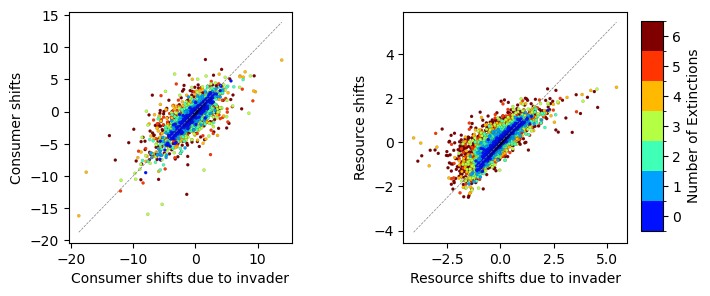

In [15]:
downsampled_data = downsample_data(monod_unpacked_data, 1)
N_shifts, R_shifts, weighted_invader_impact_N, weighted_invader_impact_R=shift_invader_impacts(downsampled_data)


figure_width = 3
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.4, figure_width))

num_ext_list = []
for sim_Nbool, sim_Rbool in zip(downsampled_data['sim_Nbools'], downsampled_data['sim_Rbools']):
    Nextbool = np.logical_not(sim_Nbool)
    Rextbool = np.logical_not(sim_Rbool)
    num_ext_list.append(sum(Nextbool) + sum(Rextbool))
    
# Extend the color to the same length of shifts
Nextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Nextended_num_ext_list += [num_ext_list[i]] * len(N_shifts[i])

Rextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Rextended_num_ext_list += [num_ext_list[i]] * len(R_shifts[i])

# Flatten arrays for sorting
x1 = -np.concatenate(weighted_invader_impact_N)
y1 = np.concatenate(N_shifts)

x2 = -np.concatenate(weighted_invader_impact_R)
y2 = np.concatenate(R_shifts)

# Create structured arrays for sorting
N_data = np.array(list(zip(Nextended_num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
R_data = np.array(list(zip(Rextended_num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_N_data = np.sort(N_data, order='extinctions')[::-1]
sorted_R_data = np.sort(R_data, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_Nextinctions = sorted_N_data['extinctions']
sorted_x1 = sorted_N_data['x']
sorted_y1 = sorted_N_data['y']

sorted_Rextinctions = sorted_R_data['extinctions']
sorted_x2 = sorted_R_data['x']
sorted_y2 = sorted_R_data['y']

# Define boundaries and colormap
boundaries = np.arange(-1.5,7.5)
norm = BoundaryNorm(boundaries, ncolors=256)

# Create the scatter plot with discrete colors for the first plot
scatter1 = ax[0].scatter(sorted_x1, sorted_y1,
                         s=5,
                         c=sorted_Nextinctions,
                         cmap='jet',
                         alpha=1,
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.07)

ax[0].set_ylabel('Consumer shifts')
ax[0].set_xlabel('Consumer shifts due to invader')

# Add dashed line where x=y for the first plot
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[0].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

# Add a separate axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter1, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(sorted_Nextinctions), np.max(boundaries)))
cbar.set_label('Number of Extinctions')
cbar.ax.set_ylim(np.min(sorted_Nextinctions)-0.5, np.max(boundaries) )
# Create the scatter plot with discrete colors for the second plot
scatter2 = ax[1].scatter(sorted_x2, sorted_y2,
                         s=5,
                         alpha=1,
                         c=sorted_Rextinctions,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.07)

ax[1].set_ylabel('Resource shifts')
ax[1].set_xlabel('Resource shifts due to invader')

# Add dashed line where x=y for the second plot
max_limit_2 = max(sorted_x2.max(), sorted_y2.max())
min_limit_2 = min(sorted_x2.min(), sorted_y2.min())
ax[1].plot([min_limit_2, max_limit_2], [min_limit_2, max_limit_2], color='gray', linestyle='dashed', linewidth=0.5)

plt.subplots_adjust(wspace=0.5)
plt.savefig('Monod shifts.pdf', bbox_inches='tight')
plt.show()

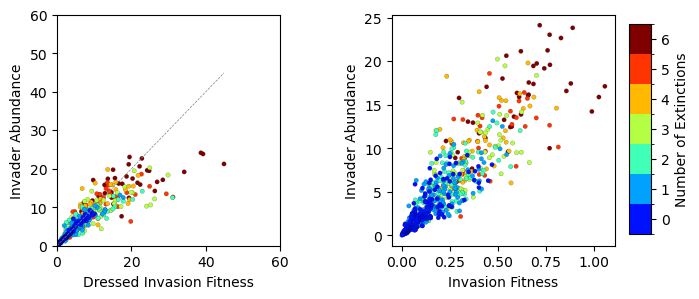

In [16]:
downsampled_data = downsample_data(monod_unpacked_data, 1)

# Calculate the number of extinctions
num_ext_list = []
for sim_Nbool, sim_Rbool in zip(downsampled_data['sim_Nbools'], downsampled_data['sim_Rbools']):
    Nextbool = np.logical_not(sim_Nbool)
    Rextbool = np.logical_not(sim_Rbool)
    num_ext_list.append(sum(Nextbool) + sum(Rextbool))
figure_width = 3
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.4, figure_width))

# Define boundaries and colormap
boundaries = np.arange(-1.5, 7.5)
norm = BoundaryNorm(boundaries, ncolors=256)

invader_abundance = np.array([arr[-1] for arr in downsampled_data['simulationN_after']])

# Data for the first plot
x1 = np.multiply(np.concatenate(downsampled_data['invasion_fitness']),
                      np.concatenate(np.concatenate(downsampled_data['Minv'])))
y1 = invader_abundance

# Create a structured array for sorting
data1 = np.array(list(zip(num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_data1 = np.sort(data1, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_1 = sorted_data1['extinctions']
sorted_x1 = sorted_data1['x']
sorted_y1 = sorted_data1['y']

# Create the scatter plot with discrete colors for the first plot
scatter1 = ax[0].scatter(sorted_x1, sorted_y1,
                         s=10,
                         c=sorted_num_ext_list_1,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

# Add dashed line where x=y for the first plot
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[0].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

ax[0].set_ylabel('Invader Abundance')
ax[0].set_xlabel('Dressed Invasion Fitness')
ax[0].set_xlim(0, 60)
ax[0].set_ylim(0, 60)

# Add a separate axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter1, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(sorted_num_ext_list_1), np.max(sorted_num_ext_list_1) + 1))
cbar.set_label('Number of Extinctions')
cbar.ax.set_ylim(np.min(sorted_num_ext_list_1)-0.5, np.max(boundaries) )
# Data for the second plot
x2 = np.concatenate(downsampled_data['invasion_fitness'])
y2 = invader_abundance

# Create a structured array for sorting
data2 = np.array(list(zip(num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_data2 = np.sort(data2, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_2 = sorted_data2['extinctions']
sorted_x2 = sorted_data2['x']
sorted_y2 = sorted_data2['y']

# Create the scatter plot with discrete colors for the second plot
scatter2 = ax[1].scatter(sorted_x2, sorted_y2,
                         s=10,
                         alpha=1,
                         c=sorted_num_ext_list_2,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

ax[1].set_ylabel('Invader Abundance')
ax[1].set_xlabel('Invasion Fitness')

plt.subplots_adjust(wspace=0.5)
plt.savefig('Monod dressed invasion fitness.pdf', bbox_inches='tight')
plt.show()

In [ ]:


assumptions = {
    "num_knock_offs": 0,
    "num_invaders": 1,
    "top_species": 30,
    "resources": 30,
    "C_mean": 3,
    "C_std_dev": 1,
    "rho": 1,
    "u_mean": 1,
    "u_std_dev": 0,
    "k_mean": 3,
    "k_std_dev": 0,
    "deltam_mean": 0,
    "deltam_std_dev": 0,    
    'h':3,
}

# Define h values to test
h_values = np.linspace( 3,8,10)
num_systems_per_h = 100

# Store results for each h value
all_relative_errors = []
all_h_values = []
all_relative_C_shift = []
print("Starting simulations for different h values...")

for h_val in h_values:
    print(f"Simulating {num_systems_per_h} systems for h = {h_val}")
    
    # Update assumptions with current h value
    current_assumptions = assumptions.copy()
    current_assumptions['h'] = h_val
    
    # Simulate systems for current h value
    with Pool() as pool:
        temp_results = [pool.apply_async(simulate_single_system, args=(current_assumptions,))
                       for _ in range(num_systems_per_h)]
        
        output_data = [res.get() for res in temp_results]
    
    # Calculate relative error for invader abundance
    for result in output_data:
        # Extract invader abundance from simulation and prediction
        simulation_invader = result['invader_ODE_steady_states']
        prediction_invader = result['invader_predictions']
        R_sur_before = result['simulationR_before'][result['sim_Rbools']]
        R_sur_after = result['simulationR_after'][result['sim_Rbools']]
        
        # Calculate relative error (same as in the original code)
        if simulation_invader > 0:  # Only calculate if invader survived in simulation
            relative_error = np.abs(simulation_invader - prediction_invader) / simulation_invader
            all_relative_errors.append(relative_error)
            all_h_values.append(h_val)
            all_relative_C_shift.append(np.mean(abs(1/(h_val+R_sur_before)-1/(h_val+R_sur_after))/(1/(h_val+R_sur_before))))

# Convert to numpy arrays
all_relative_errors = np.array(all_relative_errors)
all_h_values = np.array(all_h_values)




# Calculate statistics for each h value
unique_h_values = np.unique(all_h_values)
mean_errors = []
std_errors = []
median_errors = []

for h_val in unique_h_values:
    mask = all_h_values == h_val
    errors = all_relative_errors[mask]
    
    # Calculate statistics in log scale
    log_errors = np.log10(errors)
    mean_errors.append(np.mean(log_errors))
    std_errors.append(np.std(log_errors)/np.sqrt(len(errors)))
    median_errors.append(np.median(log_errors))


Starting simulations for different h values...
Simulating 100 systems for h = 3.0
Simulating 100 systems for h = 3.5555555555555554
Simulating 100 systems for h = 4.111111111111111
Simulating 100 systems for h = 4.666666666666667
Simulating 100 systems for h = 5.222222222222222
Simulating 100 systems for h = 5.777777777777778
Simulating 100 systems for h = 6.333333333333334


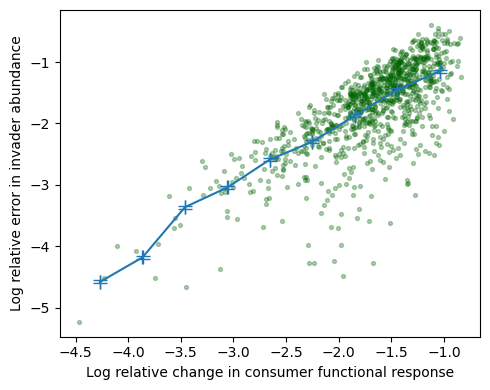

In [ ]:
# Create bins for relative C shift and errors
log_relative_errors = np.log10(all_relative_errors)
log_relative_C_shift = np.log10(all_relative_C_shift)


# Create bins and bin centers
log_c_shift_bins = np.linspace(min(log_relative_C_shift), max(log_relative_C_shift), 10)
bin_centers = (log_c_shift_bins[:-1] + log_c_shift_bins[1:]) / 2

# Initialize arrays for mean and std
mean_log_error = []
std_log_error = []
mean_log_c_shift = []

# Calculate statistics for each bin
for i in range(len(log_c_shift_bins)-1):
    mask = (log_relative_C_shift >= log_c_shift_bins[i]) & (log_relative_C_shift < log_c_shift_bins[i+1])
    if np.sum(mask) > 0:  # Only include bins with data points
        mean_log_error.append(np.mean(log_relative_errors[mask]))
        std_log_error.append(np.std(log_relative_errors[mask])/np.sqrt(np.sum(mask)))  # SEM
        mean_log_c_shift.append(bin_centers[i])

# Convert to numpy arrays
mean_log_error = np.array(mean_log_error)
std_log_error = np.array(std_log_error)
mean_log_c_shift = np.array(mean_log_c_shift)

# Create 2D histogram of relative error vs relative C shift
plt.figure(figsize=(5,4))

# Convert relative errors to log scale and create bins
# log_relative_errors = np.log10(all_relative_errors)
# log_relative_C_shift= np.log10(all_relative_C_shift)
# error_bins = np.linspace(min(log_relative_errors), max(log_relative_errors), 10)

# # Create bins for relative C shift 
# log_c_shift_bins = np.linspace(min(log_relative_C_shift), max(log_relative_C_shift), 10)

# Create scatter plot
plt.scatter(np.log10(all_relative_C_shift), log_relative_errors, alpha=0.3, s=8,c='darkgreen')

#plt.colorbar(label='Count')
plt.xlabel('Log relative change in consumer functional response')
plt.ylabel('Log relative error in invader abundance')

# # Add mean error line
# mean_log_c_shift = []
# mean_log_error = []
# log_c_shift_centers = (log_relative_C_shift[:-1] + log_relative_C_shift[1:])/2


# for i in range(len(log_c_shift_bins)-1):
#     mask = (log_relative_C_shift >= log_c_shift_bins[i]) & (log_relative_C_shift < log_c_shift_bins[i+1])
#     if np.any(mask):
#         mean_log_error.append(np.mean(log_relative_errors[mask]))
#         mean_log_c_shift.append(log_c_shift_centers[i])

# # # Plot mean with error bars
plt.errorbar(mean_log_c_shift, mean_log_error, 
            yerr=np.std(log_relative_errors)/np.sqrt(len(log_relative_errors)), 
            xerr=np.std(all_relative_C_shift)/np.sqrt(len(all_relative_C_shift)),
            capsize=5, capthick=1,label='Mean Error ± SEM')

# #plt.plot(mean_c_shift, mean_log_error, 'r-', label='Mean Error')
# plt.legend()

plt.tight_layout()
plt.show()

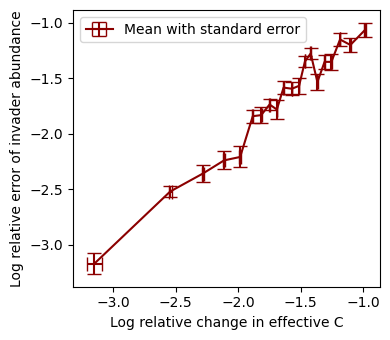

In [ ]:
# Create equal frequency bins for relative C shift
n_bins = 20
n_points = len(log_relative_C_shift)
points_per_bin = n_points // n_bins

# Sort the C shift values and get bin edges that create equal frequency bins
sorted_indices = np.argsort(log_relative_C_shift)
log_c_shift_bins = np.array([log_relative_C_shift[sorted_indices[i*points_per_bin]] 
                            for i in range(n_bins)])
log_c_shift_bins = np.append(log_c_shift_bins, log_relative_C_shift[sorted_indices[-1]])

# Initialize arrays for mean and std
mean_log_error = []
std_log_error = []
mean_log_c_shift = []
std_log_c_shift = []
# Calculate statistics for each equal frequency bin
for i in range(len(log_c_shift_bins)-1):
    mask = (log_relative_C_shift >= log_c_shift_bins[i]) & (log_relative_C_shift < log_c_shift_bins[i+1])
    if np.sum(mask) > 0:  # Only include bins with data points
        mean_log_error.append(np.mean(log_relative_errors[mask]))
        std_log_error.append(np.std(log_relative_errors[mask])/np.sqrt(np.sum(mask)))  # SEM
        mean_log_c_shift.append(np.mean(log_relative_C_shift[mask]))  # Use mean of actual points in bin
        std_log_c_shift.append(np.std(log_relative_C_shift[mask])/np.sqrt(np.sum(mask)))  # SEM


# Convert to numpy arrays
mean_log_error = np.array(mean_log_error)
std_log_error = np.array(std_log_error)
mean_log_c_shift = np.array(mean_log_c_shift)

# Create 2D histogram of relative error vs relative C shift
plt.figure(figsize=(4,3.5))

# Create scatter plot
# plt.scatter(np.log10(all_relative_C_shift), log_relative_errors, alpha=0.3, s=8,c='darkgreen')

#plt.colorbar(label='Count')
plt.xlabel('Log relative change in effective C')
plt.ylabel('Log relative error of invader abundance')



# # # Plot mean with error bars
plt.errorbar(mean_log_c_shift, mean_log_error, 
            yerr=std_log_error,
            xerr=std_log_c_shift,
             markersize=6,
            capsize=5, capthick=1,label='Mean with standard error',c='darkred')
plt.tight_layout()
plt.legend()
plt.savefig('relative_error_vs_C_shift.pdf', format="pdf")
plt.show()

In [ ]:


# assumptions = {
#     "num_knock_offs": 0,
#     "num_invaders": 1,
#     "top_species": 30,
#     "resources": 30,
#     "C_mean": 3,
#     "C_std_dev": 1,
#     "rho": 1,
#     "u_mean": 1,
#     "u_std_dev": 0,
#     "k_mean": 3,
#     "k_std_dev": 0,
#     "deltam_mean": 0,
#     "deltam_std_dev": 0,    
#     'h':3,
# }

# # Define h values to test
# h_values = np.linspace( 2.5,7,10)
# num_systems_per_h = 300

# # Store results for each h value
# all_relative_errors = []
# all_h_values = []
# all_C_shift = []

# print("Starting simulations for different h values...")

# for h_val in h_values:
#     print(f"Simulating {num_systems_per_h} systems for h = {h_val}")
    
#     # Update assumptions with current h value
#     current_assumptions = assumptions.copy()
#     current_assumptions['h'] = h_val
    
#     # Simulate systems for current h value
#     with Pool() as pool:
#         temp_results = [pool.apply_async(simulate_single_system, args=(current_assumptions,))
#                        for _ in range(num_systems_per_h)]
        
#         output_data = [res.get() for res in temp_results]
    
#     # Calculate relative error for invader abundance
#     for result in output_data:
#         # Extract invader abundance from simulation and prediction
#         simulation_invader = result['invader_ODE_steady_states']
#         prediction_invader = result['invader_predictions']
        
#         # Calculate relative error (same as in the original code)
#         if simulation_invader > 0:  # Only calculate if invader survived in simulation
#             relative_error = np.abs(simulation_invader - prediction_invader) / simulation_invader
#             all_relative_errors.append(relative_error)
#             all_h_values.append(h_val)

# # Convert to numpy arrays
# all_relative_errors = np.array(all_relative_errors)
# all_h_values = np.array(all_h_values)

# # Calculate statistics for each h value
# unique_h_values = np.unique(all_h_values)
# mean_errors = []
# std_errors = []
# median_errors = []

# for h_val in unique_h_values:
#     mask = all_h_values == h_val
#     errors = all_relative_errors[mask]
    
#     # Calculate statistics in log scale
#     log_errors = np.log10(errors)
#     mean_errors.append(np.mean(log_errors))
#     std_errors.append(np.std(log_errors)/np.sqrt(len(errors)))
#     median_errors.append(np.median(log_errors))


Starting simulations for different h values...
Simulating 300 systems for h = 2.5


KeyboardInterrupt: 

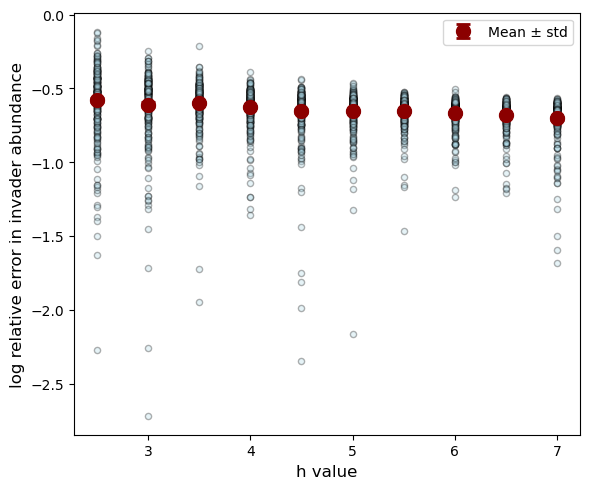


Summary Statistics:
h_value | Mean_log_error | Std_log_error | Median_log_error | Num_systems
----------------------------------------------------------------------
   2.5 |       -0.578 |        0.014 |          -0.527 |        300
   3.0 |       -0.609 |        0.014 |          -0.547 |        300
   3.5 |       -0.599 |        0.009 |          -0.569 |        300
   4.0 |       -0.626 |        0.008 |          -0.594 |        300
   4.5 |       -0.653 |        0.011 |          -0.609 |        300
   5.0 |       -0.654 |        0.008 |          -0.620 |        300
   5.5 |       -0.651 |        0.006 |          -0.625 |        300
   6.0 |       -0.666 |        0.005 |          -0.639 |        300
   6.5 |       -0.676 |        0.006 |          -0.653 |        300
   7.0 |       -0.702 |        0.008 |          -0.671 |        300


In [ ]:

# Create the plot
plt.figure(figsize=(6, 5))

# Plot individual points
plt.scatter(all_h_values, np.log10(all_relative_errors), alpha=0.3, s=20, c='lightblue', edgecolor='black')

# Plot mean with error bars
plt.errorbar(unique_h_values, mean_errors, yerr=std_errors, 
             fmt='o', capsize=5, capthick=2, ecolor='darkred', 
             markersize=10, color='darkred', linewidth=2, label='Mean ± std')

# Plot median
#plt.plot(unique_h_values, median_errors, 's-', markersize=8, color='darkgreen', linewidth=2, label='Median')

plt.xlabel('h value', fontsize=12)
plt.ylabel('log relative error in invader abundance', fontsize=12)
#plt.title('Relative Error in Invader Abundance Prediction vs h Value', fontsize=14)
plt.legend(fontsize=10)

# # Add some statistics as text
# plt.text(0.02, 0.98, f'Total systems: {len(all_relative_errors)}', 
#          transform=plt.gca().transAxes, verticalalignment='top', fontsize=10,
#          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig("relative_error_vs_h.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("h_value | Mean_log_error | Std_log_error | Median_log_error | Num_systems")
print("-" * 70)
for i, h_val in enumerate(unique_h_values):
    mask = all_h_values == h_val
    num_sys = np.sum(mask)
    print(f"{h_val:6.1f} | {mean_errors[i]:12.3f} | {std_errors[i]:12.3f} | {median_errors[i]:15.3f} | {num_sys:10d}") 